# Fitting K412

Using the NeXL libraries, load, plot, fit and report the quantification of a set of K412 spectra.  Loading the <code>Gadfly</code> library adds plotting support to <code>NeXLCore</code> and <code>NeXLSpectrum</code>.  NeXL uses <code>DataFrames</code> 

<div style="text-align: right"> NWMR 20-Nov-2019</div>

In [1]:
using Revise
using NeXLCore
using NeXLSpectrum
using NeXLUncertainties
using Gadfly
using DataFrames
ENV["Columns"]=160;

┌ Info: Recompiling stale cache file C:\Users\nicho\.julia\compiled\v1.2\NeXLSpectrum\8Vy5J.ji for NeXLSpectrum [6c578565-ca7f-4012-afc4-b8412d85af92]
└ @ Base loading.jl:1240


Load the spectra and examine the details in a <code>DataFrame</code>.

In [2]:
path = "K412 spectra"
fe = readEMSA("$(path)/Fe std.msa")
det = matching(fe, 132.0, 10)
unks = (i->readEMSA("$(path)/III-E K412[$i][4].msa",det,true)).(0:4)
al2o3 = readEMSA("$(path)/Al2O3 std.msa",det,true)
caf2 = readEMSA("$(path)/CaF2 std.msa",det,true)
fe = readEMSA("$(path)/Fe std.msa",det,true)
mgo = readEMSA("$(path)/MgO std.msa",det,true)
sio2 = readEMSA("$(path)/SiO2 std.msa",det,true)
asa(DataFrame, Spectrum[unks..., al2o3, caf2, fe, mgo, sio2])

10×8 DataFrame
│ Row │ Name               │ BeamEnergy │ ProbeCurrent │ LiveTime │ RealTime │ Coating                │ Integral  │ Material │
│     │ String             │ Float64⍰   │ Float64⍰     │ Float64⍰ │ Float64⍰ │ Union{Nothing, Film}   │ Float64   │ String⍰  │
├─────┼────────────────────┼────────────┼──────────────┼──────────┼──────────┼────────────────────────┼───────────┼──────────┤
│ 1   │ III-E K412[0][all] │ 20000.0    │ 1.11355      │ 235.484  │ 286.279  │                        │ 8.07948e6 │ K412     │
│ 2   │ III-E K412[1][all] │ 20000.0    │ 1.11355      │ 235.433  │ 286.218  │                        │ 8.07689e6 │ K412     │
│ 3   │ III-E K412[2][all] │ 20000.0    │ 1.11172      │ 235.45   │ 286.278  │                        │ 8.08445e6 │ K412     │
│ 4   │ III-E K412[3][all] │ 20000.0    │ 1.10989      │ 235.441  │ 286.281  │                        │ 8.08681e6 │ K412     │
│ 5   │ III-E K412[4][all] │ 20000.0    │ 1.10989      │ 235.399  │ 286.214  │                        │ 8.08124e6 │ K412     │
│ 6   │ Al2O3 std          │ 20000.0    │ 1.10989      │ 1172.19  │ 1491.48  │ 10.0 nm of Pure Carbon │ 4.9737e7  │ Al2O3    │
│ 7   │ CaF2 std           │ 20000.0    │ 1.10989      │ 1176.1   │ 1456.12  │ 10.0 nm of Pure Carbon │ 4.40595e7 │ CaF2     │
│ 8   │ Fe std             │ 20000.0    │ 1.10989      │ 1171.48  │ 1528.75  │                        │ 5.44487e7 │ Fe       │
│ 9   │ MgO std            │ 20000.0    │ 1.10637      │ 1175.78  │ 1496.02  │ 10.0 nm of Pure Carbon │ 4.98546e7 │ MgO      │
│ 10  │ SiO2 std           │ 20000.0    │ 1.10989      │ 1173.16  │ 1470.35  │ 10.0 nm of Pure Carbon │ 4.66482e7 │ SiO2     │

Plot two of the standard spectra including KLM-lines, escape peaks and coincidences.

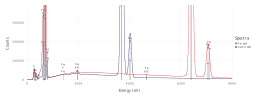

In [3]:
set_default_plot_size(10inch,4inch)
plot([fe, caf2],autoklms=true,yscale=0.2,escapes=[n"Fe K-L3", n"Ca K-L3"], coincidences=[n"Fe L3-M5", n"Fe K-L3"],xmax=8e3)

Plot all the unknowns and place KLMs based on the assigned composition of the spectra.

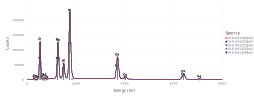

In [4]:
set_default_plot_size(10inch,4inch)
plot(unks,autoklms=true,xmax=8e3)

Build a variable width tophat filter to process the standards and the unknowns.  The detector was constructed by extracting some information from the Fe spectrum and adding additional information (see In[2])

In [5]:
filt = buildfilter(NeXLSpectrum.GaussianFilter,det)

GaussianFilter[EDS[4096 channels, E[ch] = 1.63032 + 9.99856⋅ch, 132.0 eV @ Mn Kα]]

Add the itemes to fit from the standard spectra - primarily characteristic peaks but also escape peaks.  Then process the standards using the <code>charFeature(...)</code> and <code>escapeFeature(...)</code> functions.  Collect the resulting <code>FilteredReference</code> structs into a list.

In [6]:
# Add characteristic peaks 
rr = [
    ( n"O", ktransitions, al2o3 ),
    ( n"Al", ktransitions, al2o3 ),
    ( n"Mg", ktransitions, mgo ),
    ( n"Si", ktransitions, sio2 ),
    ( n"Ca", alltransitions, caf2 ),
    ( n"Fe", alltransitions, fe ),
    ( n"O", ktransitions, al2o3 ),
]
rx = map(r ->(NeXLSpectrum.charFeature(r[1], r[2]), r[3]), rr)

# Add escape peaks
re = [
    ( n"Fe", ( n"K-L3", ), fe )
    ( n"Ca", ( n"K-L3", ), caf2)
]
append!(rx, map(r ->(NeXLSpectrum.escapeFeature(r[1], r[2]), r[3]), re))

refs = collect(Iterators.flatten((r -> filter(r[2], det, r[1], filt, 1.0/dose(r[2]))).(rx)))

12-element Array{FilteredReference,1}:
 Reference[O K-L3 + 1 other]   
 Reference[Al K-L3 + 1 other]  
 Reference[Mg K-L3 + 1 other]  
 Reference[Si K-L3 + 2 others] 
 Reference[Ca L3-M1 + 6 others]
 Reference[Ca K-L3 + 3 others] 
 Reference[Fe L3-M5 + 9 others]
 Reference[Fe K-L3 + 1 other]  
 Reference[Fe K-M3 + 1 other]  
 Reference[O K-L3 + 1 other]   
 Reference[Ecs[Fe K-L3]]       
 Reference[Ecs[Ca K-L3]]       

Use the list of <code>FilteredReference</code> structs to fit all the unknowns returning a list of <code>FilterFitResult</code> objects.  The arguments to fit are the unknown spectrum, the fitting filter (to process the unknown), the standard spectra processed into <code>FilteredReference</code> using the same filter.   The final <code>false</code> argument indicates that while negative k-ratios are removed from the fit, the last (negative) value is retained and returned.

In [7]:
res=(u->fit(u,filt,refs,false)).(unks)

5-element Array{FilterFitResult,1}:
 Unknown[III-E K412[0][all]]
 Unknown[III-E K412[1][all]]
 Unknown[III-E K412[2][all]]
 Unknown[III-E K412[3][all]]
 Unknown[III-E K412[4][all]]

Create a table of the results.  Note "Ecs[Ca K-L3]" is negative.

In [8]:
ENV["COLUMNS"] = 180
asa(DataFrame, res)

5×11 DataFrame. Omitted printing of 3 columns
│ Row │ Al K-L3 + 1 other │ Ca K-L3 + 3 others │ Ca L3-M1 + 6 others │ Ecs[Ca K-L3] │ Ecs[Fe K-L3] │ Fe K-L3 + 1 other │ Fe K-M3 + 1 other │ Fe L3-M5 + 9 others │
│     │ Float64           │ Float64            │ Float64             │ Float64      │ Float64      │ Float64           │ Float64           │ Float64             │
├─────┼───────────────────┼────────────────────┼─────────────────────┼──────────────┼──────────────┼───────────────────┼───────────────────┼─────────────────────┤
│ 1   │ 0.0679526         │ 0.192517           │ 0.698653            │ -0.021758    │ 0.084755     │ 0.0669587         │ 0.0670012         │ 0.0431755           │
│ 2   │ 0.0675981         │ 0.191921           │ 0.694794            │ -0.0339916   │ 0.0756398    │ 0.0671297         │ 0.0675214         │ 0.0427335           │
│ 3   │ 0.0679874         │ 0.192544           │ 0.704529            │ -0.0338832   │ 0.0337141    │ 0.0669217         │ 0.0670433         │ 0.0431186           │
│ 4   │ 0.0680569         │ 0.192896           │ 0.699284            │ -0.00905415  │ 0.106306     │ 0.0669195         │ 0.0678473         │ 0.0426915           │
│ 5   │ 0.0681712         │ 0.192474           │ 0.700359            │ -0.0296124   │ 0.0916067    │ 0.0669814         │ 0.0668079         │ 0.0420916           │

Here we reprocess the unknowns but with the final argument <code>true</code>.  Now the returned value for "Esc[Ca K-L3]" is set to zero.  <code>false</code> is the better option if the results from multiple fits are to be averaged to increase the sensitivity for trace elements.

In [9]:
asa(DataFrame, (u->NeXLSpectrum.fit(u,filt,refs,true)).(unks))

5×11 DataFrame. Omitted printing of 3 columns
│ Row │ Al K-L3 + 1 other │ Ca K-L3 + 3 others │ Ca L3-M1 + 6 others │ Ecs[Ca K-L3] │ Ecs[Fe K-L3] │ Fe K-L3 + 1 other │ Fe K-M3 + 1 other │ Fe L3-M5 + 9 others │
│     │ Float64           │ Float64            │ Float64             │ Float64      │ Float64      │ Float64           │ Float64           │ Float64             │
├─────┼───────────────────┼────────────────────┼─────────────────────┼──────────────┼──────────────┼───────────────────┼───────────────────┼─────────────────────┤
│ 1   │ 0.0679526         │ 0.192517           │ 0.698653            │ 0.0          │ 0.084755     │ 0.0669587         │ 0.0670012         │ 0.0431755           │
│ 2   │ 0.0675981         │ 0.191921           │ 0.694794            │ 0.0          │ 0.0756398    │ 0.0671297         │ 0.0675214         │ 0.0427335           │
│ 3   │ 0.0679874         │ 0.192544           │ 0.704529            │ 0.0          │ 0.0337141    │ 0.0669217         │ 0.0670433         │ 0.0431186           │
│ 4   │ 0.0680569         │ 0.192896           │ 0.699284            │ 0.0          │ 0.106306     │ 0.0669195         │ 0.0678473         │ 0.0426915           │
│ 5   │ 0.0681712         │ 0.192474           │ 0.700359            │ 0.0          │ 0.0916067    │ 0.0669814         │ 0.0668079         │ 0.0420916           │

In [10]:
asa(DataFrame, res[1])

12×10 DataFrame
│ Row │ Label                       │ Feature             │ Reference │ Start │ Stop  │ K         │ dK          │ Peak      │ Back      │ PtoB    │
│     │ NeXLSpectrum.UnknownLabel   │ NeXLSpec…           │ String    │ Int64 │ Int64 │ Float64   │ Float64     │ Float64   │ Float64   │ Float64 │
├─────┼─────────────────────────────┼─────────────────────┼───────────┼───────┼───────┼───────────┼─────────────┼───────────┼───────────┼─────────┤
│ 1   │ Unknown[III-E K412[0][all]] │ Al K-L3 + 1 other   │ Al2O3 std │ 134   │ 164   │ 0.0679526 │ 4.25048e-5  │ 622267.0  │ 1.84332e5 │ 101.259 │
│ 2   │ Unknown[III-E K412[0][all]] │ Ca K-L3 + 3 others  │ CaF2 std  │ 350   │ 420   │ 0.192517  │ 6.12631e-5  │ 1.16138e6 │ 2.06511e5 │ 393.611 │
│ 3   │ Unknown[III-E K412[0][all]] │ Ca L3-M1 + 6 others │ CaF2 std  │ 20    │ 52    │ 0.698653  │ 0.00153482  │ 489543.0  │ 459614.0  │ 34.0789 │
│ 4   │ Unknown[III-E K412[0][all]] │ Ecs[Ca K-L3]        │ CaF2 std  │ 180   │ 212   │ -0.021758 │ 0.056517    │ 409595.0  │ 4.10366e5 │ 31.9352 │
│ 5   │ Unknown[III-E K412[0][all]] │ Ecs[Fe K-L3]        │ Fe std    │ 445   │ 489   │ 0.084755  │ 0.00615174  │ 98899.0   │ 97734.6   │ 44.5178 │
│ 6   │ Unknown[III-E K412[0][all]] │ Fe K-L3 + 1 other   │ Fe std    │ 616   │ 666   │ 0.0669587 │ 3.68958e-5  │ 342811.0  │ 70944.2   │ 241.571 │
│ 7   │ Unknown[III-E K412[0][all]] │ Fe K-M3 + 1 other   │ Fe std    │ 683   │ 729   │ 0.0670012 │ 0.000143908 │ 93319.0   │ 56180.9   │ 76.397  │
│ 8   │ Unknown[III-E K412[0][all]] │ Fe L3-M5 + 9 others │ Fe std    │ 50    │ 91    │ 0.0431755 │ 0.00012     │ 905587.0  │ 8.4219e5  │ 44.08   │
│ 9   │ Unknown[III-E K412[0][all]] │ Mg K-L3 + 1 other   │ MgO std   │ 112   │ 140   │ 0.147951  │ 5.17226e-5  │ 1.13642e6 │ 2.10387e5 │ 151.222 │
│ 10  │ Unknown[III-E K412[0][all]] │ O K-L3 + 1 other    │ Al2O3 std │ 41    │ 65    │ 0.31532   │ 0.000126316 │ 919385.0  │ 5.14154e5 │ 42.9094 │
│ 11  │ Unknown[III-E K412[0][all]] │ O K-L3 + 1 other    │ Al2O3 std │ 41    │ 65    │ 0.31532   │ 0.000126316 │ 919385.0  │ 5.14154e5 │ 42.9094 │
│ 12  │ Unknown[III-E K412[0][all]] │ Si K-L3 + 2 others  │ SiO2 std  │ 159   │ 195   │ 0.351705  │ 8.18213e-5  │ 2.25095e6 │ 2.52688e5 │ 320.643 │

Concatenate the k-ratio summary <code>DataFrame</code> for each spectrum into a single table and then sort the table by the spectrum feature. 

In [16]:
df=vcat( (asa(DataFrame, r) for r in res)...)
sort!(df, :Feature)

60×10 DataFrame
│ Row │ Label                       │ Feature             │ Reference │ Start │ Stop  │ K         │ dK          │ Peak     │ Back      │ PtoB    │
│     │ NeXLSpectrum.UnknownLabel   │ NeXLSpec…           │ String    │ Int64 │ Int64 │ Float64   │ Float64     │ Float64  │ Float64   │ Float64 │
├─────┼─────────────────────────────┼─────────────────────┼───────────┼───────┼───────┼───────────┼─────────────┼──────────┼───────────┼─────────┤
│ 1   │ Unknown[III-E K412[0][all]] │ Ca L3-M1 + 6 others │ CaF2 std  │ 20    │ 52    │ 0.698653  │ 0.00153482  │ 489543.0 │ 459614.0  │ 34.0789 │
│ 2   │ Unknown[III-E K412[1][all]] │ Ca L3-M1 + 6 others │ CaF2 std  │ 20    │ 52    │ 0.694794  │ 0.00153863  │ 489492.0 │ 4.59735e5 │ 34.0664 │
│ 3   │ Unknown[III-E K412[2][all]] │ Ca L3-M1 + 6 others │ CaF2 std  │ 20    │ 52    │ 0.704529  │ 0.00154564  │ 490046.0 │ 4.59919e5 │ 34.0912 │
│ 4   │ Unknown[III-E K412[3][all]] │ Ca L3-M1 + 6 others │ CaF2 std  │ 20    │ 52    │ 0.699284  │ 0.0015457   │ 492060.0 │ 4.62208e5 │ 34.0618 │
│ 5   │ Unknown[III-E K412[4][all]] │ Ca L3-M1 + 6 others │ CaF2 std  │ 20    │ 52    │ 0.700359  │ 0.00154388  │ 491457.0 │ 4.61564e5 │ 34.0675 │
│ 6   │ Unknown[III-E K412[0][all]] │ O K-L3 + 1 other    │ Al2O3 std │ 41    │ 65    │ 0.31532   │ 0.000126316 │ 919385.0 │ 5.14154e5 │ 42.9094 │
│ 7   │ Unknown[III-E K412[0][all]] │ O K-L3 + 1 other    │ Al2O3 std │ 41    │ 65    │ 0.31532   │ 0.000126316 │ 919385.0 │ 5.14154e5 │ 42.9094 │
│ 8   │ Unknown[III-E K412[1][all]] │ O K-L3 + 1 other    │ Al2O3 std │ 41    │ 65    │ 0.316392  │ 0.000126443 │ 920791.0 │ 5.1427e5  │ 42.9653 │
│ 9   │ Unknown[III-E K412[1][all]] │ O K-L3 + 1 other    │ Al2O3 std │ 41    │ 65    │ 0.316392  │ 0.000126443 │ 920791.0 │ 5.1427e5  │ 42.9653 │
│ 10  │ Unknown[III-E K412[2][all]] │ O K-L3 + 1 other    │ Al2O3 std │ 41    │ 65    │ 0.316574  │ 0.000126668 │ 921244.0 │ 5.15128e5 │ 42.9149 │
⋮
│ 50  │ Unknown[III-E K412[4][all]] │ Ecs[Fe K-L3]        │ Fe std    │ 445   │ 489   │ 0.0916067 │ 0.0061807   │ 99175.0  │ 97921.1   │ 44.557  │
│ 51  │ Unknown[III-E K412[0][all]] │ Fe K-L3 + 1 other   │ Fe std    │ 616   │ 666   │ 0.0669587 │ 3.68958e-5  │ 342811.0 │ 70944.2   │ 241.571 │
│ 52  │ Unknown[III-E K412[1][all]] │ Fe K-L3 + 1 other   │ Fe std    │ 616   │ 666   │ 0.0671297 │ 3.69424e-5  │ 343735.0 │ 71232.6   │ 241.242 │
│ 53  │ Unknown[III-E K412[2][all]] │ Fe K-L3 + 1 other   │ Fe std    │ 616   │ 666   │ 0.0669217 │ 3.69688e-5  │ 343180.0 │ 71948.7   │ 238.455 │
│ 54  │ Unknown[III-E K412[3][all]] │ Fe K-L3 + 1 other   │ Fe std    │ 616   │ 666   │ 0.0669195 │ 3.7022e-5   │ 342882.0 │ 72117.1   │ 237.692 │
│ 55  │ Unknown[III-E K412[4][all]] │ Fe K-L3 + 1 other   │ Fe std    │ 616   │ 666   │ 0.0669814 │ 3.69908e-5  │ 342530.0 │ 71562.1   │ 239.289 │
│ 56  │ Unknown[III-E K412[0][all]] │ Fe K-M3 + 1 other   │ Fe std    │ 683   │ 729   │ 0.0670012 │ 0.000143908 │ 93319.0  │ 56180.9   │ 76.397  │
│ 57  │ Unknown[III-E K412[1][all]] │ Fe K-M3 + 1 other   │ Fe std    │ 683   │ 729   │ 0.0675214 │ 0.000143748 │ 93393.0  │ 55974.6   │ 76.7394 │
│ 58  │ Unknown[III-E K412[2][all]] │ Fe K-M3 + 1 other   │ Fe std    │ 683   │ 729   │ 0.0670433 │ 0.000144132 │ 93568.0  │ 56472.9   │ 76.2048 │
│ 59  │ Unknown[III-E K412[3][all]] │ Fe K-M3 + 1 other   │ Fe std    │ 683   │ 729   │ 0.0678473 │ 0.00014442  │ 93454.0  │ 55977.4   │ 76.7857 │
│ 60  │ Unknown[III-E K412[4][all]] │ Fe K-M3 + 1 other   │ Fe std    │ 683   │ 729   │ 0.0668079 │ 0.000144138 │ 93213.0  │ 56317.0   │ 76.1258 │

Finally we use the support for Gadfly plotting in NeXLSpectrum to plot the fit results including the original spectrum, the residual spectrum, the fit ROIs and the resulting k-ratio (relative to the standard.)

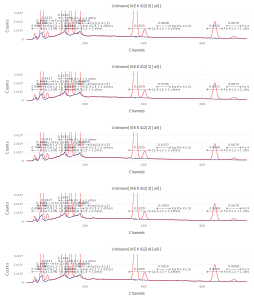

In [18]:
using CSV
CSV.write("$path/kratios.csv", df)
set_default_plot_size(10inch, 12inch)
vstack((r->plot(r,1:750)).(res))

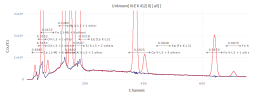

In [13]:
set_default_plot_size(10inch,4inch)
plot(res[1],1:750)

Using the statistics summary capabilities in <code>DataFrames</code> to produce a statistical summary of the k-ratio results.  The <code>true</code> argument to <code>convert(...)</code> adds fit uncertainties.

In [14]:
describe(asa(DataFrame, res, true), :mean, :std, :min, :q25, :median, :q75, :max)

22×8 DataFrame
│ Row │ variable               │ mean        │ std         │ min         │ q25         │ median      │ q75         │ max         │
│     │ Symbol                 │ Float64     │ Float64     │ Float64     │ Float64     │ Float64     │ Float64     │ Float64     │
├─────┼────────────────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ 1   │ Al K-L3 + 1 other      │ 0.0679532   │ 0.000215387 │ 0.0675981   │ 0.0679526   │ 0.0679874   │ 0.0680569   │ 0.0681712   │
│ 2   │ U(Al K-L3 + 1 other)   │ 4.25999e-5  │ 9.45857e-8  │ 4.25048e-5  │ 4.25048e-5  │ 4.26122e-5  │ 4.26597e-5  │ 4.27181e-5  │
│ 3   │ Ca K-L3 + 3 others     │ 0.19247     │ 0.000350214 │ 0.191921    │ 0.192474    │ 0.192517    │ 0.192544    │ 0.192896    │
│ 4   │ U(Ca K-L3 + 3 others)  │ 6.13426e-5  │ 9.94867e-8  │ 6.12247e-5  │ 6.12631e-5  │ 6.13432e-5  │ 6.144e-5    │ 6.14421e-5  │
│ 5   │ Ca L3-M1 + 6 others    │ 0.699524    │ 0.00349756  │ 0.694794    │ 0.698653    │ 0.699284    │ 0.700359    │ 0.704529    │
│ 6   │ U(Ca L3-M1 + 6 others) │ 0.00154173  │ 4.82381e-6  │ 0.00153482  │ 0.00153863  │ 0.00154388  │ 0.00154564  │ 0.0015457   │
│ 7   │ Ecs[Ca K-L3]           │ -0.0256599  │ 0.0105314   │ -0.0339916  │ -0.0338832  │ -0.0296124  │ -0.021758   │ -0.00905415 │
│ 8   │ U(Ecs[Ca K-L3])        │ 0.0565767   │ 4.98324e-5  │ 0.056517    │ 0.0565576   │ 0.0565718   │ 0.056583    │ 0.0566538   │
│ 9   │ Ecs[Fe K-L3]           │ 0.0784044   │ 0.027377    │ 0.0337141   │ 0.0756398   │ 0.084755    │ 0.0916067   │ 0.106306    │
│ 10  │ U(Ecs[Fe K-L3])        │ 0.00618142  │ 2.07209e-5  │ 0.00615174  │ 0.00617645  │ 0.0061807   │ 0.00618946  │ 0.00620874  │
│ 11  │ Fe K-L3 + 1 other      │ 0.0669822   │ 8.64441e-5  │ 0.0669195   │ 0.0669217   │ 0.0669587   │ 0.0669814   │ 0.0671297   │
│ 12  │ U(Fe K-L3 + 1 other)   │ 3.6964e-5   │ 4.8039e-8   │ 3.68958e-5  │ 3.69424e-5  │ 3.69688e-5  │ 3.69908e-5  │ 3.7022e-5   │
│ 13  │ Fe K-M3 + 1 other      │ 0.0672442   │ 0.000427304 │ 0.0668079   │ 0.0670012   │ 0.0670433   │ 0.0675214   │ 0.0678473   │
│ 14  │ U(Fe K-M3 + 1 other)   │ 0.000144069 │ 2.5541e-7   │ 0.000143748 │ 0.000143908 │ 0.000144132 │ 0.000144138 │ 0.00014442  │
│ 15  │ Fe L3-M5 + 9 others    │ 0.0427622   │ 0.000433972 │ 0.0420916   │ 0.0426915   │ 0.0427335   │ 0.0431186   │ 0.0431755   │
│ 16  │ U(Fe L3-M5 + 9 others) │ 0.000119883 │ 1.30026e-7  │ 0.000119675 │ 0.000119858 │ 0.000119903 │ 0.000119981 │ 0.00012     │
│ 17  │ Mg K-L3 + 1 other      │ 0.148257    │ 0.000329255 │ 0.147886    │ 0.147951    │ 0.148309    │ 0.148527    │ 0.148614    │
│ 18  │ U(Mg K-L3 + 1 other)   │ 5.18312e-5  │ 9.85587e-8  │ 5.17226e-5  │ 5.17372e-5  │ 5.18437e-5  │ 5.19227e-5  │ 5.19297e-5  │
│ 19  │ O K-L3 + 1 other       │ 0.317018    │ 0.00138171  │ 0.31532     │ 0.316392    │ 0.316574    │ 0.318       │ 0.318806    │
│ 20  │ U(O K-L3 + 1 other)    │ 0.000126735 │ 3.78321e-7  │ 0.000126316 │ 0.000126443 │ 0.000126668 │ 0.000127075 │ 0.000127173 │
│ 21  │ Si K-L3 + 2 others     │ 0.351992    │ 0.000798935 │ 0.350822    │ 0.351705    │ 0.351968    │ 0.35272     │ 0.352747    │
│ 22  │ U(Si K-L3 + 2 others)  │ 8.19637e-5  │ 1.60848e-7  │ 8.17731e-5  │ 8.18213e-5  │ 8.19931e-5  │ 8.21116e-5  │ 8.21191e-5  │